In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from ahrs.filters import Madgwick, Mahony
from pprint import pprint
from scipy import signal
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

2023-11-13 19:40:21.845824: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 19:40:21.847721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 19:40:21.883186: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 19:40:21.884562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 19:40:22.567590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Check for TensorFlow GPU access.
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version.
print(f"TensorFlow version: {tf.__version__}")

# If you are on ARM-based MacOS this will return "command not found".
# In that case, you need to consider the output of above statements. 
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# This is useful on Google Colab to check if high-RAM is selected.
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.13.0
GPU 0: NVIDIA RTX A6000 (UUID: GPU-76748847-01f8-4453-46b2-72ba4a516e70)


2023-11-13 19:38:40.443067: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Mon Nov 13 19:38:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:65:00.0 Off |                  Off |
| 30%   36C    P0              69W / 300W |      7MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Matching

We have **2 data sources** that we need to match:
1. Built-in parameters data that contain the anomaly labels.
2. Nicla Sense ME data where we apply the anomaly detection algorithms.

We should correctly match the anomalous labels we got from the 1st data to 2nd.

#### The reasons for the mismatch in data sources:
1. Even thought we set both freqs to 20Hz with the given available libraries, we see that the freqs differ around **18Hz to 22Hz**.
2. The Nicla stopped **after the industrial robotic arm** (estimatedly few minutes.)
3. The Nicla **started earlier** than the industrial robotic arm.

If the freq was exactly **20Hz**, we would had **1728000** data points after 24 hours.

Now we match the data sources based on the **location of the first anomalous point**.

In [3]:
# Generate Nicla dataframe, perform initial checks.
# If local the path:
nicla_path = "../datasets/nicla.csv"

# We skip first 6 rows due to faulty format/data.
nicla = pd.read_csv(nicla_path, on_bad_lines='warn', skiprows=6, 
                    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"])

# Check if there are any empty/Nan variables. 
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


In [4]:
# We know that Gyro. noise occurs at range of 0 < x < 1, so we find the first point where x >= 1
index = np.argmax(nicla['GyroX'][:1000].diff().abs() >= 1)

# Drop the first 898 points.
nicla_dropped = nicla.iloc[897:] # => 898 is index.
# Reset the index.

nicla_dropped.index = pd.RangeIndex(len(nicla_dropped.index))
# Generate df from dataset that contains labels/built-in parameters.
# Path for local PC.
right_arm_csv_path = "../datasets/right_arm.csv"

# Generate the dataframe.
right_arm = pd.read_csv(right_arm_csv_path, on_bad_lines='warn')

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

# Get the lengths of nicla and arm data.
len_nicla_dropped = len(nicla_dropped)
len_right_arm = len(right_arm)

print(f"The length of the right arm data is {len_right_arm}")
print(f"The length of the nicla data is {len_nicla_dropped}")

# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785
The final 1 is located at: 1728006


We run the test for just a bit more than 24 hours, while setting operation to normal after 24 hours.

The final 1 is at 1728006, well, this makes sense, because the **24 hour data at 20Hz means 1728000 data points**. We only have **6 extra** data points in this case.

We now **match the datasets**.

Now we try to find corresponding points at Nicla.

In [5]:
# Remove the rest of the data.
right_arm = right_arm[0:1728000]
# Check the anomaly labels.
df_anol = right_arm["Anomaly State"]
# Find the first anomaly point.
idx_f = (df_anol == 1.0).idxmax()

# Get the GyroX feature.
df_gyroX = nicla_dropped["GyroX"]
# Convert into numpy array.
gyroX = df_gyroX.to_numpy()
# Get first 1 m data points that we know its normal.
gyroX_1m = gyroX[0:1000000]
gyroX_1m_min = np.min(gyroX_1m)
gyroX_1m_max = np.max(gyroX_1m)

# Find the data either bigger than max or lower then min.
greater_indices = np.argwhere(gyroX > gyroX_1m_max)
lesser_indices = np.argwhere(gyroX < gyroX_1m_min)

first_greater = greater_indices[0][0]
first_lesser = lesser_indices[0][0]
last_greater = greater_indices[-1][0]
last_lesser = lesser_indices[-1][0]

print(f"The first greater than max at {first_greater}, the first lesser than min at {first_lesser}.")
print(f"The first anomaly point in Arm data seen at {idx_f}.")
print(f"The final anomaly point in Arm data seen at {index_of_last_one}.")
print(f"The final anomaly point in Nicla-Gyro data seen at {last_lesser}.")

The first greater than max at 1072794, the first lesser than min at 1072917.
The first anomaly point in Arm data seen at 1080004.
The final anomaly point in Arm data seen at 1728006.
The final anomaly point in Nicla-Gyro data seen at 1629872.


We start anomalies **after 15 hours** (corresponds to data point at 1080000). 

However, when we manually try to label the Nicla data based on min-max thresholding the GyroX feature, anomalies seems to start at 1072794.

Thus, we need to analyze further.

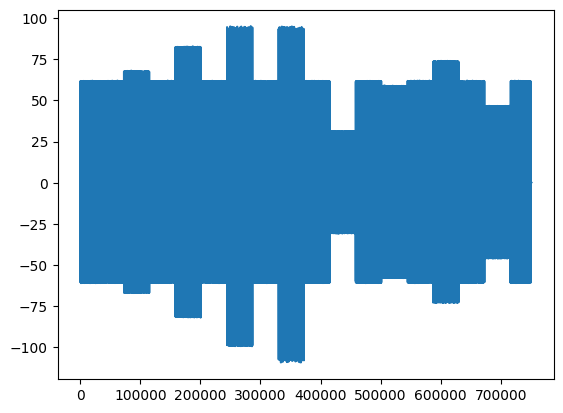

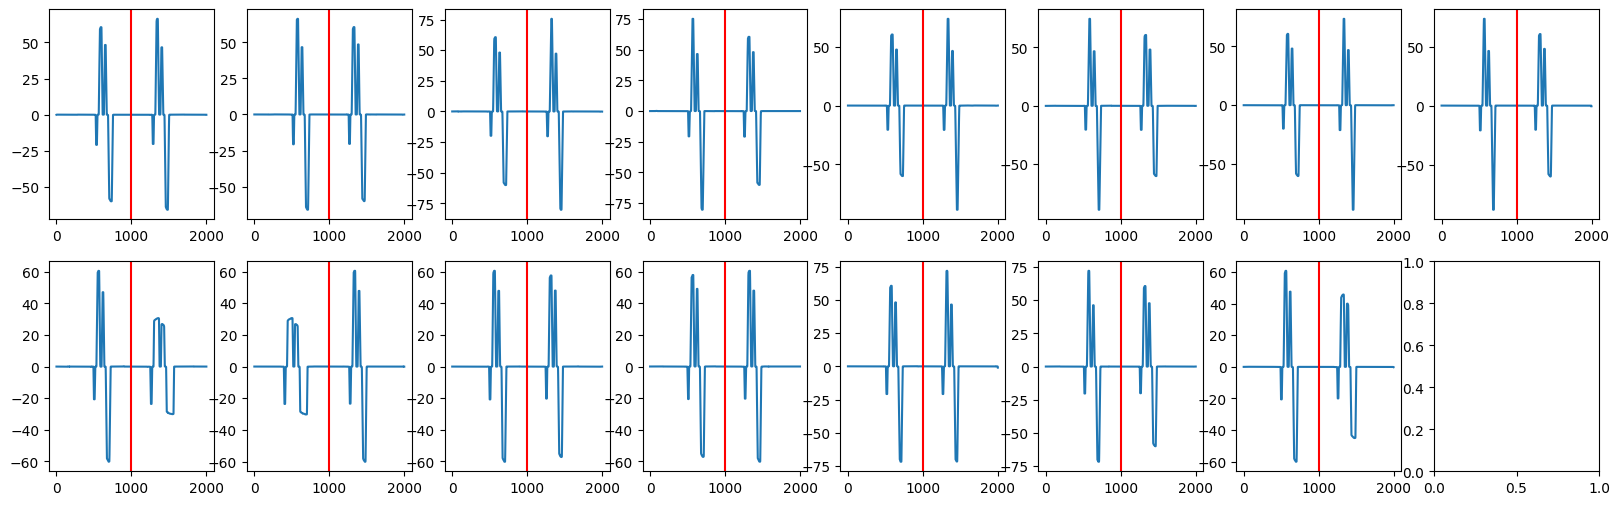

In [6]:
# Remove the first 1m points as we know they are normal.
gyroX_a_1m = gyroX[1000000:]
plt.plot(gyroX_a_1m)
plt.show()

# First we need to filter the noise.
# Remove the rest (after the final anomaly point).
nicla_fixed = nicla_dropped[:1716474+1]

# Set window size for moving median.
f_window_size = 20

# Apply moving median and convert back to numpy array for faster ops.
nicla_filtered= nicla_fixed.rolling(f_window_size).median().dropna().to_numpy()

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), 
      (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)) = plt.subplots(nrows=2, ncols=8, figsize=(20, 6))
# First jump seen at around 1072450.
ax1.plot(nicla_filtered[1071450:1073450, 3])
ax1.axvline(x=1000, color='red')
# First down seen at around 1115125.
ax2.plot(nicla_filtered[1114125:1116125, 3])
ax2.axvline(x=1000, color='red')
# Second jump seen at around 1158150.
ax3.plot(nicla_filtered[1157150:1159150, 3])
ax3.axvline(x=1000, color='red')
# Second down seen at around 1201100.
ax4.plot(nicla_filtered[1200100:1202100, 3])
ax4.axvline(x=1000, color='red')
# Third up seen at around 1244100.
ax5.plot(nicla_filtered[1243100:1245100, 3])
ax5.axvline(x=1000, color='red')
# Third down seen at around 1286875.
ax6.plot(nicla_filtered[1285875:1287875, 3])
ax6.axvline(x=1000, color='red')
# Fourth up seen at around 1329900.
ax7.plot(nicla_filtered[1328900:1330900, 3])
ax7.axvline(x=1000, color='red')
# Fourth down seen at around 1372650.
ax8.plot(nicla_filtered[1371675:1373675, 3])
ax8.axvline(x=1000, color='red')
# Fifth down seen at around 1415700.
ax9.plot(nicla_filtered[1414700:1416700, 3])
ax9.axvline(x=1000, color='red')
# Fifth up seen at around 1458415.
ax10.plot(nicla_filtered[1457415:1459415, 3])
ax10.axvline(x=1000, color='red')
# Sixth down seen at around 1501500.
ax11.plot(nicla_filtered[1500475:1502475, 3])
ax11.axvline(x=1000, color='red')
# Sixth up seen at around 1544725.
ax12.plot(nicla_filtered[1543725:1545725, 3])
ax12.axvline(x=1000, color='red')
# Seventh up seen at around 1587750.
ax13.plot(nicla_filtered[1586750:1588750, 3])
ax13.axvline(x=1000, color='red')
# Seventh down seen at around 1630150.
ax14.plot(nicla_filtered[1629150:1631150, 3])
ax14.axvline(x=1000, color='red')
# Eighth down seen at around 1673200.
ax15.plot(nicla_filtered[1672200:1674200, 3])
ax15.axvline(x=1000, color='red')
# Then rest of the data is an anomaly.
plt.show()

We **manually** detect (error rate is < 1%) starting and ending points of anomaly event manually from the above graphs.
The anomalies are seen at below intervals (after 1m points):
1. **10% increase** at joint velocity between **72450 - 115125**.
1. **35% increase** at joint velocity between **158150 - 201100**.
1. **65% increase** at joint velocity between **244100 - 286875**.
1. **100% increase** at joint velocity between **329900 - 372650**.
1. **50% decrease** at joint velocity between **415700 - 458415**.
1. **5% decrease** at joint velocity between **501500 - 544725**.
1. **20% increase** at joint velocity between **587750 - 630150**.
1. **25% decrease** at joint velocity between **673200 - 716456 (the final point)**.

We see that first anomaly is seen at 1072450 while the expected point is 1080000 if the data rate would be 20Hz.

1072450 corresponds to a data rate at 19.86Hz which explains the difference. The last point being at 1716456 also confirms this.

While one solution would be shifting the data based on this information, for the sake of accuracy we manually label the data.

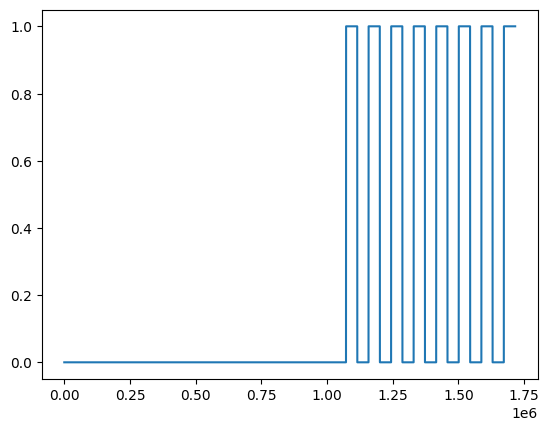

In [7]:
# Create a numpy array that will hold anomaly labels. 
len_nicla = len(nicla_filtered)
np_labels = np.zeros((len_nicla, 1))
# Set anomaly points to ones.
np_labels[1072450:1115125] = 1
np_labels[1158150:1201100] = 1
np_labels[1244100:1286875] = 1
np_labels[1329900:1372650] = 1
np_labels[1415700:1458415] = 1
np_labels[1501500:1544725] = 1
np_labels[1587750:1630150] = 1
np_labels[1673200:1716456] = 1
# Plot the labels for a visual check.
plt.plot(np_labels)
plt.show()

# Split the non-anomalous and anomalous data.
nicla_nor = nicla_filtered[:1072450]
nicla_anol = nicla_filtered[1072450:]
# We only need labels for after 1st anomalous point
# as it will be our test data.
np_labels_test = np_labels[1072450:]

# Split the features to single arrays.
np_accX = nicla_nor[:, 0]
np_accY = nicla_nor[:, 1]
np_accZ = nicla_nor[:, 2]
np_gyroX = nicla_nor[:, 3]
np_gyroY = nicla_nor[:, 4]
np_gyroZ = nicla_nor[:, 5]
np_magX = nicla_nor[:, 6]
np_magY = nicla_nor[:, 7]
np_magZ = nicla_nor[:, 8]

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

## Correlation Analysis

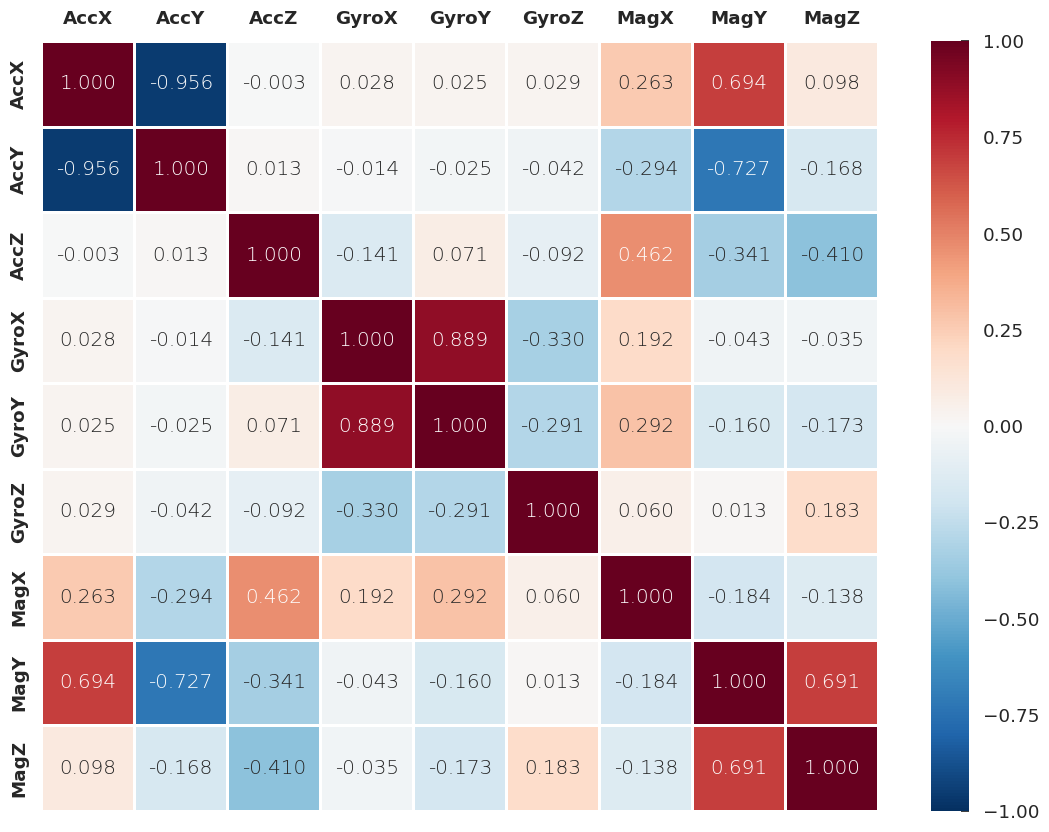

In [8]:
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=tick_labels, yticklabels=tick_labels)

# Get the colorbar object.
cbar = ax.collections[0].colorbar
# Set the location of the colorbar ticks to the right.
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_IMU.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Based on the above matrix, the highest correlated features in order are:
1. AccX and AccY with pcc = **-0.956** 
2. GyroX and GyroY with pcc = **0.889**
3. AccY and MagY with pcc = **-0.727**  

When pcc > 0.7 or pcc < -0.7, we accept that as a strong correlation. In this case, features of GyroX and GyroY, AccY and MagY seems to highly correlate.

Even though, the **single features might not correlate**, sets of features can. Now we check if accelerometer, gyroscrope and magnetometer data correlate with each other.

To find how sets of features correlate we apply **canonical-correlation analysis (CCA)**.

In [9]:
# Standardize with zero mean and unit variance / only normal data.
scaler = StandardScaler() 
acc_sc = scaler.fit_transform(np_acc)
gyro_sc = scaler.fit_transform(np_gyro) 
mag_sc = scaler.fit_transform(np_mag) 

# Apply CCA. 
n_comp = 3
cca_1 = CCA(scale=False, n_components=n_comp)
cca_2 = CCA(scale=False, n_components=n_comp)
cca_3 = CCA(scale=False, n_components=n_comp)
cca_1.fit(acc_sc, gyro_sc)
cca_2.fit(acc_sc, mag_sc)
cca_3.fit(gyro_sc, mag_sc)
acc_c_1, gyro_c_1 = cca_1.transform(acc_sc, gyro_sc)
acc_c_2, mag_c_1 = cca_2.transform(acc_sc, mag_sc)
gyro_c_2, mag_c_2 = cca_3.transform(gyro_sc, mag_sc)

# Canonical variate correlations.
acc_gyro_corr = [np.corrcoef(acc_c_1[:, i], gyro_c_1[:, i])[1][0] for i in range(n_comp)]
acc_mag_corr = [np.corrcoef(acc_c_2[:, i], mag_c_1[:, i])[1][0] for i in range(n_comp)]
gyro_mag_corr = [np.corrcoef(gyro_c_2[:, i], mag_c_2[:, i])[1][0] for i in range(n_comp)]

print(f"Acc-Gyro cvc: {acc_gyro_corr}")
print(f"Acc-Mag cvc: {acc_mag_corr}")
print(f"Gyro-Mag cvc: {gyro_mag_corr}")

Acc-Gyro cvc: [0.4856142661636787, 0.07371715418811822, 0.028344309945593636]
Acc-Mag cvc: [0.9696214582282641, 0.5802248892976098, 0.27068518080662735]
Gyro-Mag cvc: [0.41173840407552265, 0.3043020156228818, 0.07603021337917881]


This confirms our previous per feature correlation analysis.

In this case, the **accelerometer and magnetometer** data highly correlate.

In [10]:
# We know our data at roughly 19.86Hz.
s_period = 1 / 19.86
mad_fil = Madgwick(sample_period=s_period)
mah_fil = Mahony(sample_period=s_period)
# Set the identity quaternion, so we accept as zero rotation.
q = np.empty((len(np_acc), 4))
q_mahony = np.empty((len(np_acc), 4))
q[0] = np.array([1.0, 0.0, 0.0, 0.0])
q_mahony[0] = np.array([1.0, 0.0, 0.0, 0.0])
# Calculate quaternions.
for i in range(1, len(np_acc)):
    q[i] = mad_fil.updateMARG(q[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    q_mahony[i] = mah_fil.updateMARG(q_mahony[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])

[[ 1.          0.01543437 -0.003104    0.31948101]
 [ 0.01543437  1.         -0.2838297  -0.02259608]
 [-0.003104   -0.2838297   1.          0.01661727]
 [ 0.31948101 -0.02259608  0.01661727  1.        ]]
[[ 1.          0.46047982  0.93099665 -0.61002263]
 [ 0.46047982  1.          0.17652929 -0.83840541]
 [ 0.93099665  0.17652929  1.         -0.4621761 ]
 [-0.61002263 -0.83840541 -0.4621761   1.        ]]


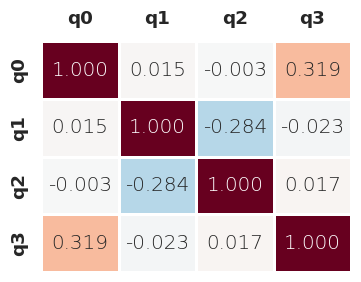

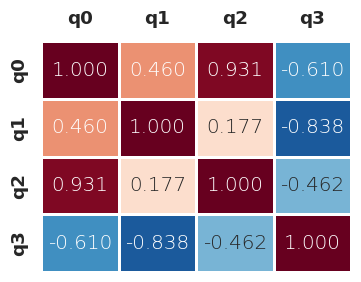

In [11]:
# Split the features to single arrays.
q_0 = q[:, 0]
q_1 = q[:, 1]
q_2 = q[:, 2]
q_3 = q[:, 3]
q_mahony_0 = q_mahony[:, 0]
q_mahony_1 = q_mahony[:, 1]
q_mahony_2 = q_mahony[:, 2]
q_mahony_3 = q_mahony[:, 3]

# Check how input features correlate with each other.
corr_mad = cal_corr([q_0, q_1, q_2, q_3])
corr_mah = cal_corr([q_mahony_0, q_mahony_1, q_mahony_2, q_mahony_3])
print(corr_mad)
print(corr_mah)

# Visualize the correlation map of Madgwick.
q_tick_labels = ["q0", "q1", "q2", "q3"]
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mad, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_madgwick.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Visualize the correlation map of Mahony.
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mah, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('../figures/corr_heatmap_mahony.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The quaternions of Madgwick do not highly correlate.

The highly correlated quaternion features of **Mahony** filtering are:
1. **q0** and **q2** with pcc = **0.931**
2. **q1** and **q3** with pcc = **-0.838**

The quaternions generated via Mahony seems to correlate more than Madgwick generated ones.

This makes **Madgwick** more suitable for the regression analysis.

## Anomaly Detection
### Null Model (Always Yes)
1 means anomaly, 0 means normal.

In [12]:
# Count the number of actual anomalies (1s)
num_anomalies = np.sum(np_labels_test)

# Calculate the total number of instances
total_instances = np_labels_test.size

# Recall is 1.0 because we are predicting all instances as anomalies
recall = 1.0

# Precision is the number of true positives divided by the total number of predicted positives
# Here, predicted positives are equal to the total number of instances
precision = num_anomalies / total_instances

# F1 Score is 2 times the product of precision and recall divided by the sum of precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy when predicting all as anomalies: {precision}")
print(f"Recall when predicting all as anomalies: {recall}")
print(f"Precision when predicting all as anomalies: {precision}")
print(f"F1 Score when predicting all as anomalies: {f1_score}")

Accuracy when predicting all as anomalies: 0.5322093272422928
Recall when predicting all as anomalies: 1.0
Precision when predicting all as anomalies: 0.5322093272422928
F1 Score when predicting all as anomalies: 0.6946953236476845


### Baseline

In [13]:
# Find autocorrelation example.
def df_autocorr(df, lag=1, axis=0):
    """
    Compute the full-sample column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.
    axis : int, optional (default=0)
        The axis along which to compute the autocorrelation.

    Returns:
    --------
    pandas.Series
        A Series containing the autocorrelation coefficients for each column of the input DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

def df_rolling_autocorr(df, window, lag=1):
    """
    Compute the rolling column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window : int
        The size of the rolling window.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the rolling autocorrelation coefficients for each column of the input DataFrame.
    """

    return (df.rolling(window=window)
        .corr(df.shift(lag)))

def df_autocorr_highest(df, window_min, window_max, lag_f):
    """
    Compute the highest mean correlation with respect to window length for each column of a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window_min : int
        The minimum window size to consider.
    window_max : int
        The maximum window size to consider.
    lag_f : int
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the highest mean correlation and corresponding window size for each column of the input DataFrame.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(df.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max): 
            corr = df_rolling_autocorr(df.iloc[:,i], window=j, lag=lag_f).dropna().mean()
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = df.columns[i] + "_corr"    
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict

# First we find how anomalous part autocorrelates.
corr = df_autocorr_highest(pd.DataFrame(nicla_anol, columns=tick_labels), 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9957346283953076, 755],
 'AccY_corr': [0.9989053364695906, 753],
 'AccZ_corr': [0.976514706396234, 771],
 'GyroX_corr': [0.9977984671409795, 758],
 'GyroY_corr': [0.9966524746112579, 756],
 'GyroZ_corr': [0.9951850638555725, 751],
 'MagX_corr': [0.9985352621573919, 756],
 'MagY_corr': [0.9996707877734609, 764],
 'MagZ_corr': [0.9991869677688926, 755]}


We see that due to the anomalies, this data **do not correlate** like non-anomalous data.

In [14]:
# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]

# Define non-scaled version.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))

pd_IMU_data = pd.DataFrame(IMU_non_scaled, columns=tick_labels)

# Get sample start / end points.
s_start = 300000
s_end = 400000

# Find the window length that generates highest r (pearson correlation coefficient).
corr = df_autocorr_highest(pd_IMU_data[s_start:s_end], 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9956480501872034, 755],
 'AccY_corr': [0.9988926089826179, 755],
 'AccZ_corr': [0.9777193381788154, 755],
 'GyroX_corr': [0.9978351908182033, 755],
 'GyroY_corr': [0.9967375464573313, 755],
 'GyroZ_corr': [0.9952034562782655, 755],
 'MagX_corr': [0.9985234447917424, 755],
 'MagY_corr': [0.9996763904760192, 755],
 'MagZ_corr': [0.9991879996879954, 755]}


From the autocorrelation analysis, we see that data correlate highest when window length is **755**.

Data rate is ≈ 19.86Hz. So, **755** points correspond to **38 seconds**. During the test, we tried to set each arm's whole process to **40 seconds**. Thus, that is also confirmed by this analysis.

Our baseline methodology is simple:
   1. We know the periodicity. We set **periodicity to a window length** (755).
   2. We split whole dataset into input windows **with a period length**. 
   3. We generate two base windows via calculating the **mean** and **median** non-anomalous input windows.
   4. We calculate **overall RMSE** for **mean** and **median**.
   
However, there is one challenge that we need to solve. Even though, the data highly correlates with 755 points, we see that there is a **gradually increasing lag** occurring between windows.

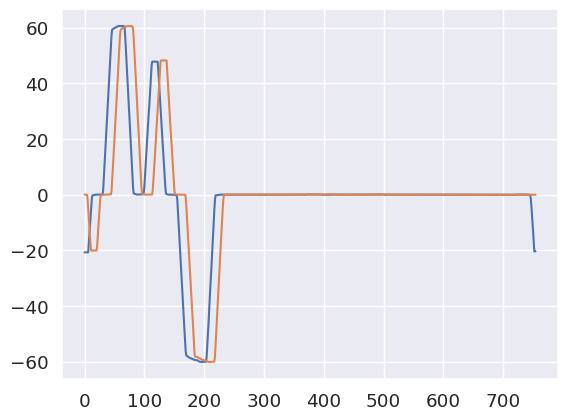

In [15]:
plt.plot(IMU_non_scaled[0:755:, 3])
plt.plot(IMU_non_scaled[755*100:755*101:, 3])
plt.show()

We need to **get rid of this lag** to come up with mean and median baseline windows.

First, we convert whole data to input windows and select random **three consecutive windows** to see if there is a lag.

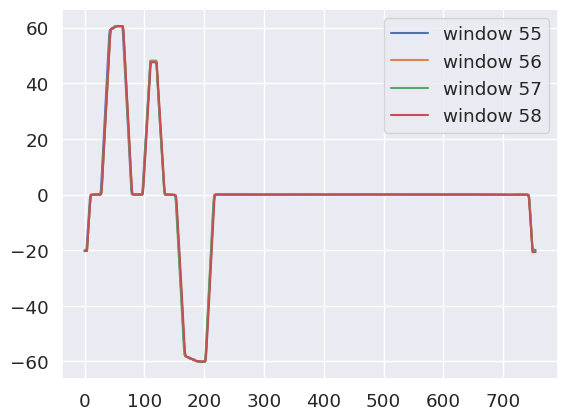

In [16]:
# Set window size.
window_size = 755
# We trim data in a way that it is exactly divided to 755.
# 1072100 data points mean 1420 windows.
IMU_cut = IMU_non_scaled[0:1072100]

# Reshape dataframe into an array of arrays with shape (1420, 755, 9).
n_windows = len(IMU_cut) // window_size

windows = np.empty((1420, 755, 9))
windows = IMU_cut[:n_windows * window_size].reshape(n_windows, window_size, -1)

# Plot windows.
plt.plot(windows[55][:, 3], label="window 55")
plt.plot(windows[56][:, 3], label="window 56")
plt.plot(windows[57][:, 3], label="window 57")
plt.plot(windows[58][:, 3], label="window 58")
plt.legend(loc="upper right")
plt.savefig('../figures/consecutive_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

As we see from above plot, the windows near-perfectly match. This confirms **the lag is near-zero** between consecutive windows.

Now we plot random **three random non-consecutive windows** to spot the lag.

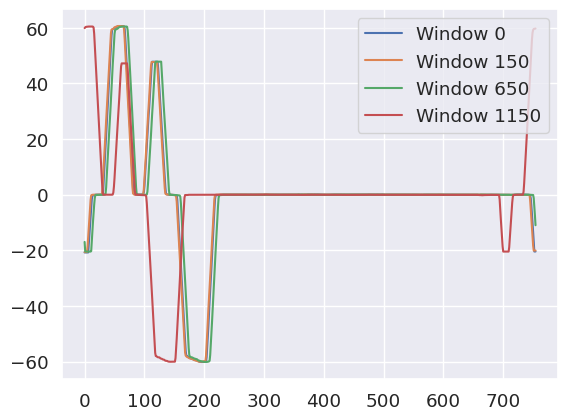

In [17]:
plt.plot(windows[0][0:755:, 3], label="Window 0")
plt.plot(windows[150][0:755, 3], label="Window 150")
plt.plot(windows[650][0:755, 3], label="Window 650")
plt.plot(windows[1150][0:755, 3], label="Window 1150")
plt.legend(loc="upper right")
plt.savefig('../figures/random_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that, the **lag is more obvius as the gap between the windows increases.**

Now we **detect the lag of all consecutive windows** to confirm what we claimed above.

In [18]:
# Find lag of two consecutive windows.
lag_meds = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[j][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
    # print(lag_arr)
    lag_meds.append(np.median(lag_arr))
# Print the max, min lags.
print(min(lag_meds), max(lag_meds))

-3.0 3.0


We confirmed the lags between consecutive windows are **negligible as only ranges from -3 to 3 data points**.

Now, we find the lag of all windows to the **first window**.

In [19]:
# Find lag of all to first window.
lag_meds = []
lag_max = []
lag_mins = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
        
    lag_meds.append(np.median(lag_arr))
    lag_max.append(max(lag_arr))
    
# Print the max, min lags.
print(f"The min med: {min(lag_meds)}, the max med:{max(lag_meds)}")
print(f"The max:{max(lag_max)}")

The min med: -34.0, the max med:114.0
The max:121


This proves that the window sampling based on just **pearson correlation analysis** becomes inadequate when there are high number of near-zero values (this is our guess, need further analysis) are present within the data.

Now, **we will get rid of the lags and align all windows to the first window to come up with a stronger baseline.**

In [20]:
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows[j+1] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows[j+1] = cut_window

Now, that all windows are aligned, **we generate the mean/median windows to be used as stronger baselines.** 

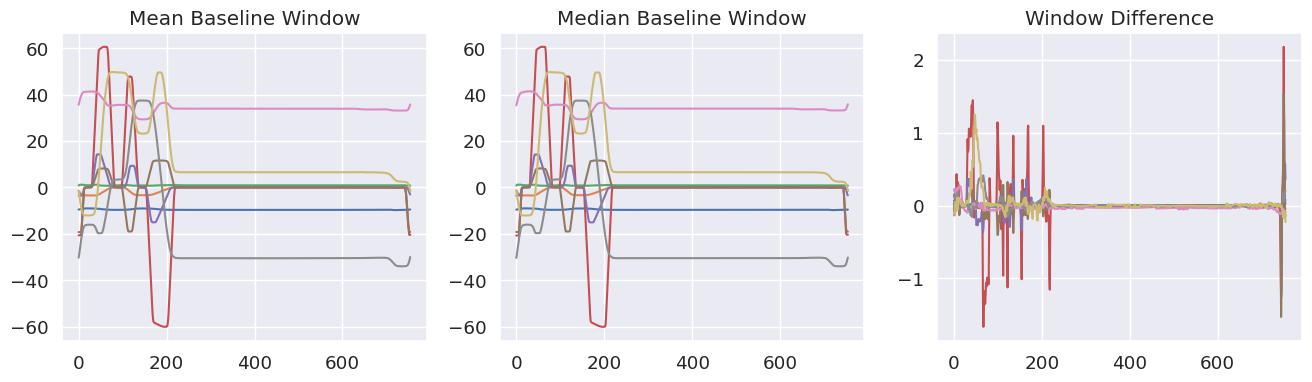

In [21]:
# Get the stronger mean/medians as baselines.
mean_window = np.mean(windows, axis=0)
median_window = np.median(windows, axis=0)

# Find difference between two windows.
diff_window = mean_window - median_window
# Visualise the baselines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(mean_window)
ax2.plot(median_window)
ax3.plot(diff_window)
ax1.set_title("Mean Baseline Window")
ax2.set_title("Median Baseline Window")
ax3.set_title("Window Difference")
plt.savefig('../figures/baseline_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [22]:
sum_rmse_mean = 0
sum_rmse_median = 0
# Sum the RMSEs per feature.
for window in windows:
    rmse_mean = np.sqrt(np.mean((window - mean_window)**2, axis=0))
    rmse_median = np.sqrt(np.mean((window - median_window)**2, axis=0))
    sum_rmse_mean += rmse_mean
    sum_rmse_median += rmse_median
mean_per_feature = sum_rmse_mean / windows.shape[0]
median_per_feature = sum_rmse_median / windows.shape[0]
overall_mean_rmse = np.mean(mean_per_feature)
overall_median_rmse = np.mean(median_per_feature)
print(f"Mean RMSE per feature: {mean_per_feature}")
print(f"Median RMSE per feature: {median_per_feature}")
print(f"Overall mean RMSE: {overall_mean_rmse}")
print(f"Overall median RMSE: {overall_median_rmse}")

Mean RMSE per feature: [0.04278741 0.07058257 0.02718    1.27839048 0.29570638 0.50613047
 0.20503904 0.49432547 0.59824453]
Median RMSE per feature: [0.04314793 0.0714159  0.028084   1.31436817 0.30415338 0.51580648
 0.20815076 0.50062956 0.61386907]
Overall mean RMSE: 0.3909318160524488
Overall median RMSE: 0.39995836045971617


We see that **mean as a baseline beats the median**, hence we will be using **mean baseline** from now on.

Now we will **detect anomalies via the mean baseline**. First, we generate the anomalous windows and check if they align with the baseline.

Length of the anomalies 644006.


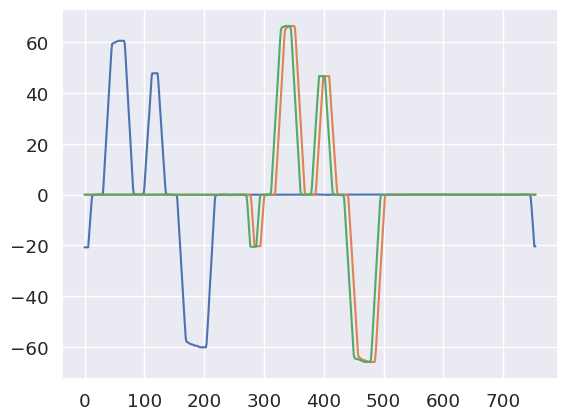

In [23]:
# Get the length of the anomalies
n_anol = len(nicla_anol)
# Print the length of the anomalies.
print(f"Length of the anomalies {n_anol}.")
# We cut in a way that it is exactly divided to window size.
anol_cut = nicla_anol[:643260]
# Reshape dataframe into an array of arrays with shape (852, 755, 9).
n_anol_windows = len(anol_cut) // window_size
windows_anol = np.empty((852, 755, 9))
windows_anol = anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# Compare random windows with the baseline window.
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[1][:, 3])
plt.show()

We see that **anomalous windows are not aligned**. They neither align with the base window nor each other.

Now **we align them.**

In [24]:
for j in range(n_anol_windows):
    lag_arr = []
    for i in range(windows_anol.shape[2]):
        x = windows[0][:, i]
        y = windows_anol[j][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows_anol[j] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows_anol[j] = cut_window

We **plot the random anomalous windows** to see if windows are aligned.

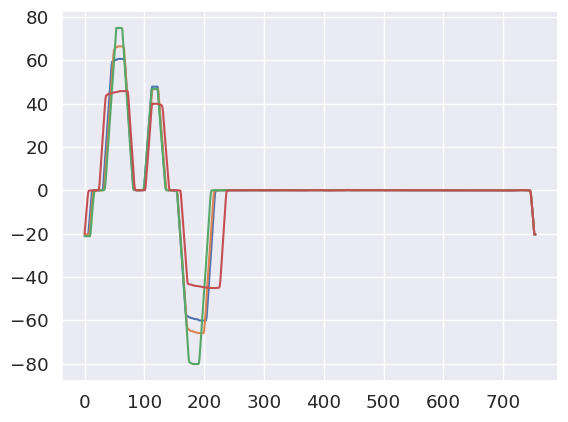

In [25]:
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[150][:, 3])
plt.plot(windows_anol[-1][:, 3])
plt.show()

Due to data having anomalies, we work with **non-normalized/standardized** data until now as **anomalies affect the standardization/normalization**. There are robust methods are available but these are not utilized under the context of anomaly detection, as we want our anomalies to stay as they are here.

However, this creates an issue during the RMSE calculation (thresholding), due to data being on different scales, **one feature's noise might contribute RMSE more than the anomaly of an another feature.**

The feature scales are shown below.

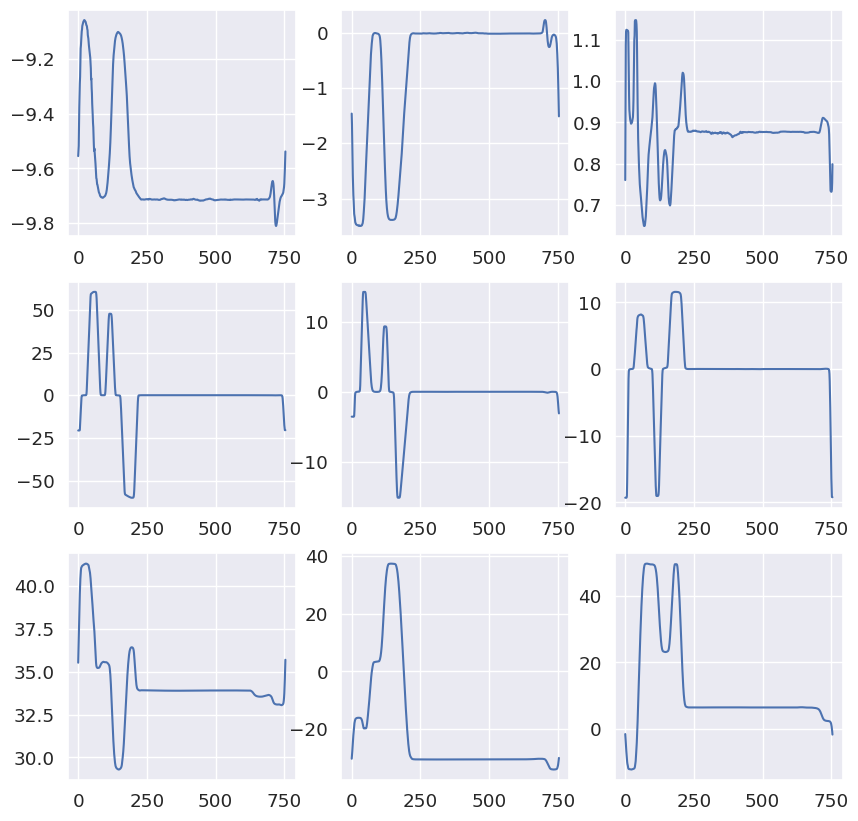

In [26]:
# Create a 3 x 3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window.shape[1]):
    axs[i].plot(mean_window[:, i])
plt.show()

For this reason, we **min-max normalize** the windows before calculating the RMSE.

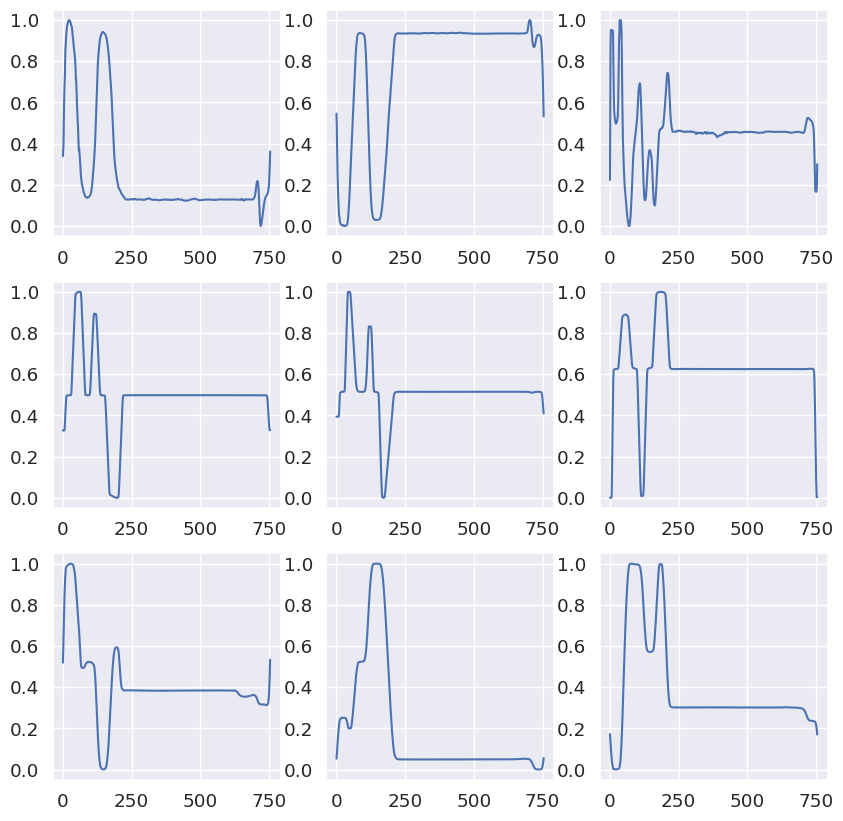

In [27]:
# Initialize a MinMaxScaler object.
scaler_mm = MinMaxScaler()

# Apply the scaler to the data.
scaler_mm.fit(mean_window)

# Scale the data.
mean_window_mm = scaler_mm.transform(mean_window)

# Create a 3 x 3 grid of subplots for scaled data.
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window_mm.shape[1]):
    axs[i].plot(mean_window_mm[:, i])
plt.show()

Now, calculate RMSE of the windows and mean baseline window.

We utilize RMSE for the following reasons.
   1. The RMSE has the same unit as the input, hence **more interpretable**. 
   2. RMSE is more **robust against extreme anomalies and noise**. These two are common in data generated by IMU sensors.

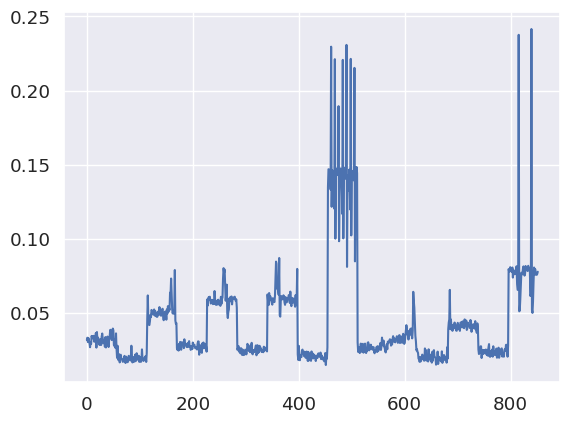

In [28]:
rmse_anols = []
# Calculate the RMSEs per feature.
for window in windows_anol:
    
    # Normalize the window via the mean window fit.
    anol_scaled = scaler_mm.transform(window)

    # 1 (anomaly) if rmse >= mean_rmse, else otherwise.
    rmse = np.mean(np.sqrt(np.mean((anol_scaled - mean_window_mm)**2, axis=0)))
    rmse_anols.append(rmse)
    
plt.plot(rmse_anols)
plt.show()

We need to set our labels correctly, as the labels we have are one per point, but we need to label our windows.

We will accept the window as **anomalous if half or more than half of the window contains anomalous points**.

Then based on a **certain threshold (found via grid search)**, we will accept the RMSE window as anomaly or not.

Grid search is a labour intensive task, thus we only provide **the final search parameters below**.

In [29]:
# Similar to windowing previously, divideable to 755.
np_labels_test_cut = np_labels_test[:643260]

# Convert into windows.
label_windows = np_labels_test_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# if sum is above 755/2 its anomaly.
label_final = []
for window in label_windows:
    if np.sum(window) > 755/2:
        label_final.append(1)
    else:
        label_final.append(0)

# Set a range of thresholds.
# We set the best one, feel free to play with these.
th = [x/10000 for x in range(380, 381, 5)]

# Label window as an anomaly, then calculate performance metrics.
baseline_results = {}
for threshold in th:
    y_pred = []
    for rmse in rmse_anols:
        if rmse >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    # Generate confusion matrix classes.
    tn, fp, fn, tp = confusion_matrix(label_final, y_pred).ravel()
    # These two are the same, this one is for heatmap.
    cf_matrix = confusion_matrix(label_final, y_pred)
    # Calculate performance metrics.
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*prec*rec) / (prec + rec)
    
    baseline_results['Accuracy'] = acc
    baseline_results['Recall'] = rec
    baseline_results['Precision'] = prec
    baseline_results['F1'] = f1
    
    pprint(baseline_results)

{'Accuracy': 0.8744131455399061,
 'F1': 0.8664169787765292,
 'Precision': 0.9971264367816092,
 'Recall': 0.7660044150110376}


In [30]:
patience = 5
batch_size = 32
sequence_stride = 1

def plot(self, model=None, plot_col='GyroY', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.plot = plot

In [31]:
CONV_WIDTH = 5 # Kernel size.
MAX_EPOCHS = 20 # Can increase more for further analysis.
NUM_FILTERS = 64
MAX_POOL_SIZE = 3
NUM_FEATURES = 9
OUT_STEPS = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# Set neural network model/parameters.
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

model.build(input_shape=(None, 755, 9))
model.summary()
# Path to save the model.
model_path = "../models/1DCNN"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 751, 64)           2944      
                                                                 
 conv1d_1 (Conv1D)           (None, 747, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 245, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 241, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 80, 64)           0         
 1D)                                                    

2023-11-13 16:18:24.559321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 16:18:24.939511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46703 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [32]:
# Split the data into 60%, 20%, 20% without shuffling
train_size = 0.6
validation_size = 0.2
test_size = 0.2

# Split the array into 60%, 20%, 20% without shuffling
# IMU_non_scaled is non-anomalous data.
train_end = int(IMU_non_scaled.shape[0] * train_size)
validation_end = train_end + int(IMU_non_scaled.shape[0] * validation_size)

# Split the array
train_data = IMU_non_scaled[:train_end]
validation_data = IMU_non_scaled[train_end:validation_end]
test_data = IMU_non_scaled[validation_end:]

print(f"Shapes are: {train_data.shape, validation_data.shape, test_data.shape}")

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data only
scaler.fit(train_data)

# labels required to transform into dataframe.

# Transform the datasets
labels = ["AccX", "AccY", "AccZ", 
          "GyroX", "GyroY", "GyroZ", 
          "MagX", "MagY", "MagZ"]

train_data_scaled = pd.DataFrame(scaler.transform(train_data), columns=labels)
validation_data_scaled = pd.DataFrame(scaler.transform(validation_data))
test_data_scaled = scaler.transform(test_data)

Shapes are: ((643470, 9), (214490, 9), (214490, 9))


In [33]:
# Set window.
w_1dcnn = WindowGenerator(input_width=window_size, label_width=OUT_SIZE, shift=OUT_SIZE,
                          train_df=train_data_scaled, val_df=validation_data_scaled, test_df = test_data_scaled)

# Verify the model input/output shape.
print('Input shape:', w_1dcnn.example[0].shape)
print('Output shape:', model(w_1dcnn.example[0]).shape)


Input shape: (32, 755, 9)


2023-11-13 16:18:26.429950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-13 16:18:27.067316: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 16:18:27.068307: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 16:18:27.068335: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-13 16:18:27.069308: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 16:18:27.069354: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Output shape: (32, 1, 9)


2023-11-13 16:18:27.636465: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


: 